In [48]:
from pytorch_lightning.loggers import WandbLogger
from ml_recon.utils.undersample_tools import gen_pdf, get_mask_from_distribution
import matplotlib.pyplot as plt
import numpy as np
from ml_recon.pl_modules.pl_learn_ssl_undersampling import LearnedSSLLightning
import torch


In [23]:
artifact_dir = WandbLogger.download_artifact(artifact='chiew-lab/MRI Reconstruction/model-x52bfb72:v0')


wandb: Downloading large artifact model-x52bfb72:v0, 540.13MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:1:16.3


In [24]:
import os
model = LearnedSSLLightning.load_from_checkpoint(os.path.join(artifact_dir, 'model.ckpt'))

In [25]:
probs = model.get_probability(True)

In [26]:
summed = probs[1].sum(0)

In [31]:
probs[1].mean((-1, -2))

tensor([0.5000, 0.5000, 0.5000, 0.5000], device='cuda:0',
       grad_fn=<MeanBackward1>)

In [27]:
summed[59:69, 59:69] = 1

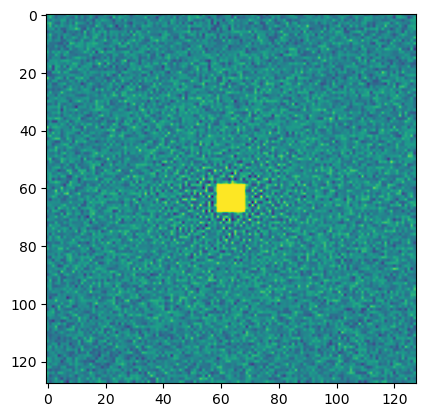

In [28]:
plt.imshow(probs[1][0].cpu().detach())

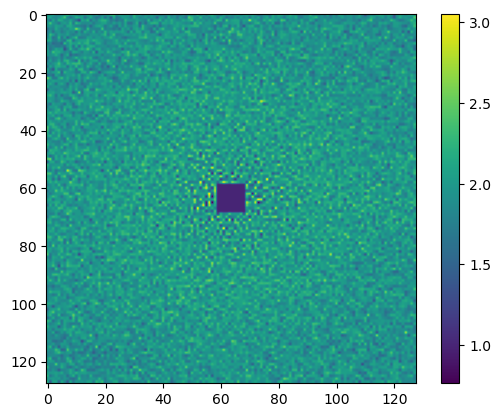

In [29]:
plt.imshow(summed.cpu().detach())
plt.colorbar()

In [37]:
with torch.no_grad():
    masks = model.get_mask(1000)

In [38]:
masks.shape

torch.Size([1000, 4, 1, 128, 128])

In [39]:
masks[0, 0, :, 0, :]

tensor([[1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
         0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1.,
         1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
         0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
         1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
         1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
         0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
         1., 0.]], device='cuda:0')

In [41]:
mask_sum = masks.sum(1)

In [80]:
def calculate_overlap_ratio(tensor):
    # Remove the singleton dimension (dimension 2)
    tensor = tensor.squeeze()

    # Sum along the second dimension (dim=1) to count the number of 1s
    sum_across_dim2 = tensor.sum(dim=1)  # Shape is [1000, 128, 128]

    # Count the number of 1s in sum_across_dim2
    count_ones = (sum_across_dim2 == 1).float().sum(dim=[1, 2])  # Shape is [1000]

    # Count the number of elements greater than 1
    count_greater_than_ones = (sum_across_dim2 > 1).float().sum(dim=[1, 2])  # Shape is [1000]

    # Calculate the ratio of 1's vs greater than 1's
    ratio = count_ones / count_greater_than_ones
    return ratio

In [59]:
ratio = calculate_overlap_ratio(masks)

In [67]:
pdf = gen_pdf(False, 128, 128, 1/2, 8, True)
pdf = np.repeat(pdf[None, :, :], 4, axis=0)

In [68]:
pdf.shape

(4, 128, 128)

In [69]:
vd_masks = [get_mask_from_distribution(pdf, np.random.default_rng(), False) for _ in range(1000)]

In [77]:
vd_masks = np.stack(vd_masks).astype(np.float32)

In [78]:
ratio_vd = calculate_overlap_ratio(torch.from_numpy(vd_masks))

In [79]:
ratio_vd.mean(
)

tensor(3.3588)

In [74]:
ratio.mean()

tensor(0.3674, device='cuda:0')

(1000, 128, 128)